In [23]:
  # packages
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [24]:
# Generates a signal of 0 and 1 that is num_cycles long
# @param num_cycle the length of the signal
# @return a tuple of the signals and schedule, schedule says how long a bit at the corresponding point in signals is active
# Example: a return of [1,1,0], [2,2,1] would indicate that the first bit (1) in signals is active for two cycles and the second bit (0) is active for one
def generate_signals(num_cycle, rate_max=1):
  signals = np.array([])

  # for simplicity now
  schedule = np.array([])

  i = 0
  while i < num_cycle:
    # 0 or 1, depending on what the sender is sending
    curr_bit = np.random.randint(low=0,high=2)
    # rate is how long a certain bit will be active for, before going to the next one
    rate = np.random.randint(low=rate_max,high=rate_max+20) # not include 21, only 1 to 20

    # if chosen length takes you past the total length, turn it down so there is not any extra
    # if not, keep same as chosen
    if i + rate > num_cycle:
      repeat_time = num_cycle - i
    else:
      repeat_time = rate

    # for the amount of repeat_time (rate if it is able, until the end if not), append corresponding schedule and rate values
    for _ in range(repeat_time):
      signals = np.append(signals, curr_bit)
      schedule = np.append(schedule, rate)
      i = i + 1
  return signals, schedule


In [25]:
# Assume we know the number of jammers plus only 1 sender

# Or maybe we can infer the number of jammers based on the amplitude of received signals?
def approx_signals_3(received_signals, schedule, num_jammer=1):
  signals = np.zeros(shape=received_signals.shape,dtype=int)
  
  # based on schedule
  
  # where to jump to after processing current bit
  next_idx = int(schedule[0])

  # how big the current bit is, use this for error correction
  window_size = schedule[0]

  i = 0
  while i < len(received_signals):
    if i >= next_idx:
      next_idx = int(next_idx + int(schedule[i]))
      window_size = schedule[i]

      # handle the edge case
      if next_idx > len(received_signals):
        next_idx = len(received_signals)
        window_size = len(received_signals) - i

    # two cases for one constant signal
    if np.any(received_signals[i:next_idx] == 0):
      # jammer 0 + sender 0 = 0
      signals[i:next_idx] = 0
      i = next_idx

    # num of jammer + 1 sender
    elif np.any(received_signals[i:next_idx] == num_jammer +1):
      # jammer 1 + sender 1 = 2
      signals[i:next_idx] = 1
      i = next_idx

    else:
      if random.random() > 0.5:
        # jammer might send 1 since higher average
        signals[i:next_idx] = 1
        i = next_idx
      else:
        # jammer might send 0 since lower average
        signals[i:next_idx] = 0
        i = next_idx
  return signals

In [26]:
def approx_signals_sliding_window(received_signals, schedule, num_jammer=1):
    signals = np.zeros(shape=received_signals.shape,dtype=int)
  
    # based on schedule
    
    # where to jump to after processing current bit
    next_idx = int(schedule[0])

    # how big the current bit is, use this for error correction
    window_size = schedule[0]

    i = 0
    while i < len(received_signals):
        if i >= next_idx:
            next_idx = int(next_idx + int(schedule[i]))
            window_size = schedule[i]

        # handle the edge case
        if next_idx > len(received_signals):
            next_idx = len(received_signals)
            window_size = len(received_signals) - i

        # two cases for one constant signal
        if np.any(received_signals[i:next_idx] == 0):
            # jammer 0 + sender 0 = 0
            signals[i:next_idx] = 0
            i = next_idx

        # num of jammer + 1 sender
        elif np.any(received_signals[i:next_idx] == num_jammer +1):
        # jammer 1 + sender 1 = 2
            signals[i:next_idx] = 1
            i = next_idx

        else:
            average_signals = np.sum(received_signals[:next_idx]) / next_idx

            if average_signals > 1:
                # jammer might send 1 since higher average
                signals[i:next_idx] = 1
                i = next_idx
            else:
                # jammer might send 0 since lower average
                signals[i:next_idx] = 0
                i = next_idx

    return signals

In [35]:
# runs for a variable jammer maximum rate
# @param num_runs the number of rns you want to take the average over
# @return the dataframe containing Time Length, Accuracy, and Jammer Max Rate arrays
def run_variable_jammer_rate(num_runs): 
  # init data frame
  df = pd.DataFrame({"Time Length":[], "Min Max Accuracy":[], "Window Accuracy":[], "Baseline Accuracy":[], "Jammer Avg Rate":[]})
  all_send = []
  all_jam = []
  time_interval = 10**3
  # get sender signals with set max rate = 21
  sender_signals, schedule = generate_signals(time_interval, 10)
  for i in range(num_runs):
    cur_min_max_accuracy = []
    cur_baseline = []
    cur_window = []
    for _ in range(10):

      # get the jammer signals with a certian max rate, determined by current innteration
      jammer_signals, _ = generate_signals(time_interval, i)

      # # get sender signals with set max rate = 21
      # sender_signals, schedule = generate_signals(time_interval, 20)

      # summing the two signals will give the recieved signals
      received_signals = jammer_signals + sender_signals

      # process the recieve through the algorithim
      processed_signals_min_max = approx_signals_3(received_signals, schedule, num_jammer=1)
      processed_signals_window = approx_signals_sliding_window(received_signals, schedule, num_jammer=1)
      processed_signals_baseline = approx_signals_baseline(received_signals, schedule, num_jammer=1)

      # determine the accuracy by summing up all the equals over the processed and sent, then taking eprcent
      min_max_accuracy = np.sum(np.equal(sender_signals, processed_signals_min_max)) * 100 / time_interval
      window_accuracy = np.sum(np.equal(sender_signals, processed_signals_window)) * 100 / time_interval
      baseline_accuracy = np.sum(np.equal(sender_signals, processed_signals_baseline)) * 100 / time_interval

      cur_min_max_accuracy.append(min_max_accuracy)
      cur_window.append(window_accuracy)
      cur_baseline.append(baseline_accuracy)

    # add the current run to the data frame
    df.loc[len(df)] = {"Time Length":time_interval, "Min Max Accuracy":sum(cur_min_max_accuracy) / len(cur_min_max_accuracy), "Window Accuracy":sum(cur_window) / len(cur_window), "Baseline Accuracy":sum(cur_baseline)/len(cur_baseline), "Jammer Avg Rate":(i+10)/20}

    all_send.append(sender_signals)
    all_jam.append(jammer_signals)

  # add average statistics
  df.loc[len(df)] = {"Time Length": df["Time Length"].mean(), "Min Max Accuracy": df["Min Max Accuracy"].mean(), "Window Accuracy": df["Window Accuracy"].mean(), "Baseline Accuracy": df["Baseline Accuracy"].mean(), "Jammer Avg Rate": (i+10)/20}
  
  accu = df["Min Max Accuracy"]
  stats = {'mean': (accu.mean()), "median": accu.median(), "min": (accu.argmin(), accu.min()), "max": (accu.argmax(), accu.max())}
  return df, stats, all_send, all_jam


In [29]:
# runs for a variable jammer maximum rate
# @param num_runs the number of rns you want to take the average over
# @return the dataframe containing Time Length, Accuracy, and Jammer Max Rate arrays
NUM_JAMMERS = 5

def run_variable_jammer_rate_more_jam(num_runs): 
  # init data frame
  df = pd.DataFrame({"Time Length":[], "Min Max Accuracy":[], "Window Accuracy":[], "Baseline Accuracy":[], "Jammer Avg Rate":[]})
  all_send = []
  all_jam = []
  time_interval = 10**3
  # get sender signals with set max rate = 21
  sender_signals, schedule = generate_signals(time_interval, 12)
  for i in range(num_runs):
    cur_accuracy = []
    for _ in range(10):

      # jammer_signals = np.array([])
      jammer_signals = generate_signals(time_interval, i)[0]

      # get the jammer signals with a certian max rate, determined by current innteration
      for _ in range(NUM_JAMMERS-1):
        jammer_signals = jammer_signals + generate_signals(time_interval, i)[0]

      # # get sender signals with set max rate = 21
      # sender_signals, schedule = generate_signals(time_interval, 20)

      # summing the two signals will give the recieved signals
      received_signals = sender_signals + jammer_signals

      # process the recieve through the algorithim
      min_max_processed = approx_signals_baseline(received_signals, schedule, num_jammer=NUM_JAMMERS)

      # determine the accuracy by summing up all the equals over the processed and sent, then taking eprcent
      accuracy = np.sum(np.equal(sender_signals, min_max_processed)) * 100 / time_interval

      cur_accuracy.append(accuracy)

    # add the current run to the data frame
    df.loc[len(df)] = {"Time Length":time_interval, "Accuracy":sum(cur_accuracy) / len(cur_accuracy), "Jammer Avg Rate":(i+10)/20}

    all_send.append(sender_signals)
    all_jam.append(jammer_signals)

  # add average statistics
  df.loc[len(df)] = {"Time Length": df["Time Length"].mean(), "Accuracy": df["Accuracy"].mean(), "Jammer Avg Rate": (i+10)/20}
  
  accu = df["Accuracy"]
  stats = {'mean': (accu.mean()), "median": accu.median(), "min": (accu.argmin(), accu.min()), "max": (accu.argmax(), accu.max())}
  return df, stats, all_send, all_jam


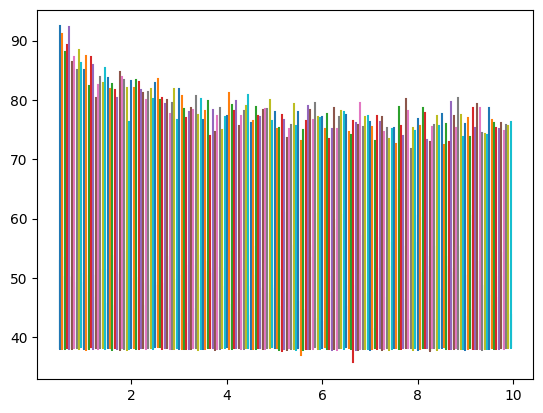

{'mean': 78.45657894736843, 'median': 77.58, 'min': (147, 71.64), 'max': (0, 92.38)}


In [39]:
df, stats, send_sig, jam_sig = run_variable_jammer_rate(190)

plt.plot(df["Jammer Avg Rate"][:-1], (df["Min Max Accuracy"][:-1], df["Window Accuracy"][:-1], df["Baseline Accuracy"][:-1]))
plt.show()

df.to_csv('variable_jammer_rate_based_on_algorithim.csv')
print(stats)